In [2]:
"""
author: Miranda Lv
Date: July, 2023
"""

In [126]:
import os
from os.path import dirname as up
import sys
sys.path.append('../utils')
import helpers

# data processing
import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import StandardScaler

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [127]:
"""
# 1	Coastal Blue	443 (20)	Yes - with Sentinel-2 band 1
# 2	Blue	490 (50)	Yes - with Sentinel-2 band 2
# 3	Green I	531 (36)	No equivalent with Sentinel-2
# 4	Green	565 (36)	Yes - with Sentinel-2 band 3
# 5	Yellow	610 (20)	No equivalent with Sentinel-2
# 6	Red	665 (31)	Yes - with Sentinel-2 band 4
# 7	Red Edge	705 (15)	Yes - with Sentinel-2 band 5
# 8	NIR	865 (40)	Yes - with Sentinel-2 band 8a
"""

'\n# 1\tCoastal Blue\t443 (20)\tYes - with Sentinel-2 band 1\n# 2\tBlue\t490 (50)\tYes - with Sentinel-2 band 2\n# 3\tGreen I\t531 (36)\tNo equivalent with Sentinel-2\n# 4\tGreen\t565 (36)\tYes - with Sentinel-2 band 3\n# 5\tYellow\t610 (20)\tNo equivalent with Sentinel-2\n# 6\tRed\t665 (31)\tYes - with Sentinel-2 band 4\n# 7\tRed Edge\t705 (15)\tYes - with Sentinel-2 band 5\n# 8\tNIR\t865 (40)\tYes - with Sentinel-2 band 8a\n'

In [186]:
# Loading data
seasonal = 'Oct-Dec_2022' #Jan-Mar_2022, Apr-Jun_2022, July-Sep_2022, Oct-Dec_2022
root_dir = up(os.getcwd())
points_data = os.path.join(root_dir, 'data/processing_data/vectors/points_planet_comp_{}.geojson'.format(seasonal)) #points_planet_composite.geojson

gdf = gpd.read_file(points_data)
# gdf.drop(columns=['rand_point'], inplace=True)
gdf.drop(columns=['type_class'], inplace=True)
df = pd.DataFrame(gdf.drop(columns='geometry'))

In [187]:
df.head()

,id,type,layer,path,B1,B2,B3,B4,B5,B6,B7,B8,dem_value
0,0,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4453,3500,2678,2393,2044,1651,1720,1229,0.481527
1,1,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4445,3459,2607,2263,1910,1597,1670,1688,0.565837
2,2,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4500,3602,2802,2565,2211,1903,2005,1841,0.214749
3,3,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4650,3855,3083,2828,2483,2121,2199,1930,1.062840
4,4,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4650,3941,3213,2980,2620,2224,2423,2104,0.586897


In [188]:
subset_attributes = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'dem_value']

alterniflora = round(df[df['type']=='alterniflora'][subset_attributes].describe(),2)
juncus = round(df[df['type']=='juncus'][subset_attributes].describe(),2)

pd.concat([alterniflora, juncus], axis=1, keys=['Alterniflora Statistics', 'Juncus Statistics'])

Alterniflora Statistics                                               \
                           B1       B2       B3       B4       B5       B6   
count                  691.00   691.00   691.00   691.00   691.00   691.00   
mean                  4454.19  3499.42  2670.84  2368.82  2012.98  1685.83   
std                    106.71   151.76   175.13   199.28   208.39   200.10   
min                   4284.00  3319.00  2467.00  2164.00  1776.00  1453.00   
25%                   4391.00  3407.00  2561.00  2244.00  1883.00  1562.00   
50%                   4429.00  3457.00  2618.00  2301.00  1942.00  1619.00   
75%                   4482.50  3538.00  2715.00  2410.50  2061.00  1731.50   
max                   5467.00  4894.00  4064.00  3773.00  3528.00  3171.00   

                                  Juncus Statistics                    \
            B7       B8 dem_value                B1       B2       B3   
count   691.00   691.00    691.00            504.00   504.00   504.00   
mean   1769.64  1720.67      0.44           4477.23  3502.58  2638.23   
std     227.18   284.56      0.15             79.25   107.67   123.14   
min    1462.00   692.00     -0.38           4323.00  3346.00  2448.00   
25%    1627.00  1539.50      0.36           4423.00  3429.00  2549.00   
50%    1690.00  1658.00      0.45           4465.00  3481.00  2610.50   
75%    1827.50  1860.00      0.50           4518.00  3556.00  2700.25   
max    3294.00  2894.00      1.12           4908.00  4181.00  3334.00   

                                                              
            B4       B5       B6       B7       B8 dem_value  
count   504.00   504.00   504.00   504.00   504.00    504.00  
mean   2313.50  1951.29  1637.86  1722.65  1917.72      0.61  
std     137.01   154.59   167.82   196.33   250.01      0.12  
min    2090.00  1699.00  1359.00  1406.00   896.00     -0.02  
25%    2216.75  1840.75  1514.00  1581.50  1765.75      0.55  
50%    2285.00  1919.50  1603.00  1680.50  1894.50      0.62  
75%    2387.00  2041.00  1724.25  1833.25  2052.25      0.68  
max    3043.00  2782.00  2573.00  2616.00  2800.00      1.01

## Univariate Analysis

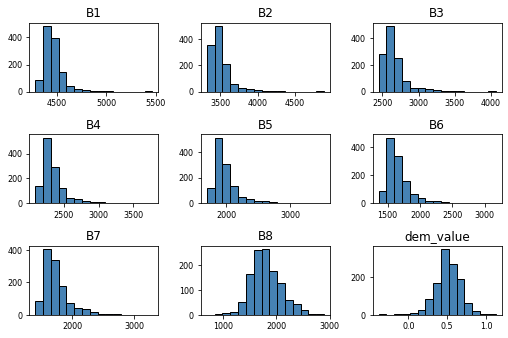

In [189]:
# all dataset
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

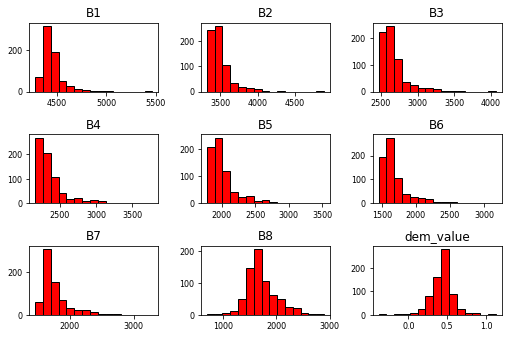

In [190]:
df[df['type']=='alterniflora'].hist(bins=15, color='red', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 

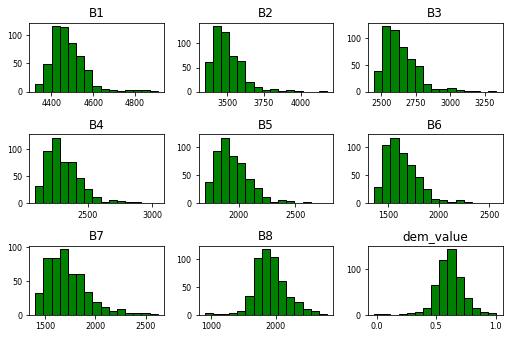

In [191]:
df[df['type']=='juncus'].hist(bins=15, color='green', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 

## Multivariate Analysis

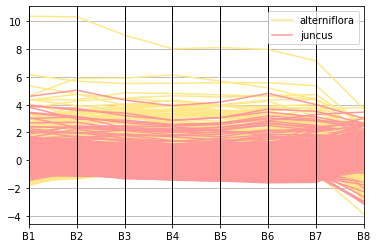

In [192]:
# data scale
# Scaling attribute values to avoid few outiers
cols = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']
subset_df = df[cols]

ss = StandardScaler()

scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
final_df = pd.concat([scaled_df, df['type']], axis=1)
final_df.head()

# plot parallel coordinates

"""
Points are represented as connected line segments. 
Each vertical line represents one data attribute. 
One complete set of connected line segments across all the attributes represents one data point. 
Hence points that tend to cluster will appear closer together. 
"""
pc = parallel_coordinates(final_df, 'type', color=('#FFE888', '#FF9999'))

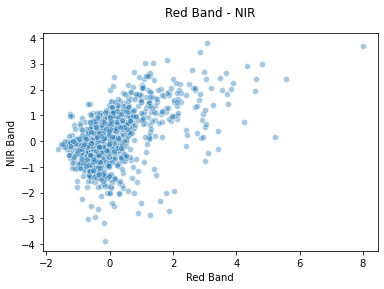

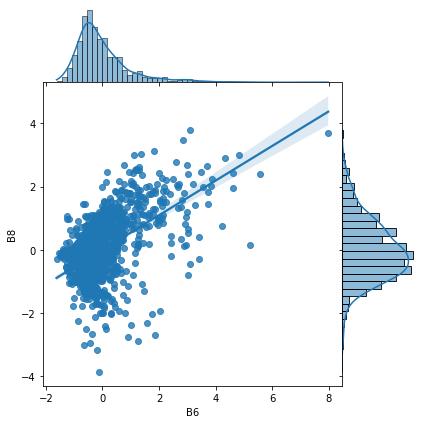

In [193]:
# Scatter Plot
plt.scatter(final_df['B6'], final_df['B8'],
            alpha=0.4, edgecolors='w')

plt.xlabel('Red Band')
plt.ylabel('NIR Band')
plt.title('Red Band - NIR',y=1.05)

# Joint Plot
jp = sns.jointplot(x='B6', y='B8', data=final_df,
                   kind='reg', space=0, ratio=4)


### Pair wise vis

/Users/mirandalv/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


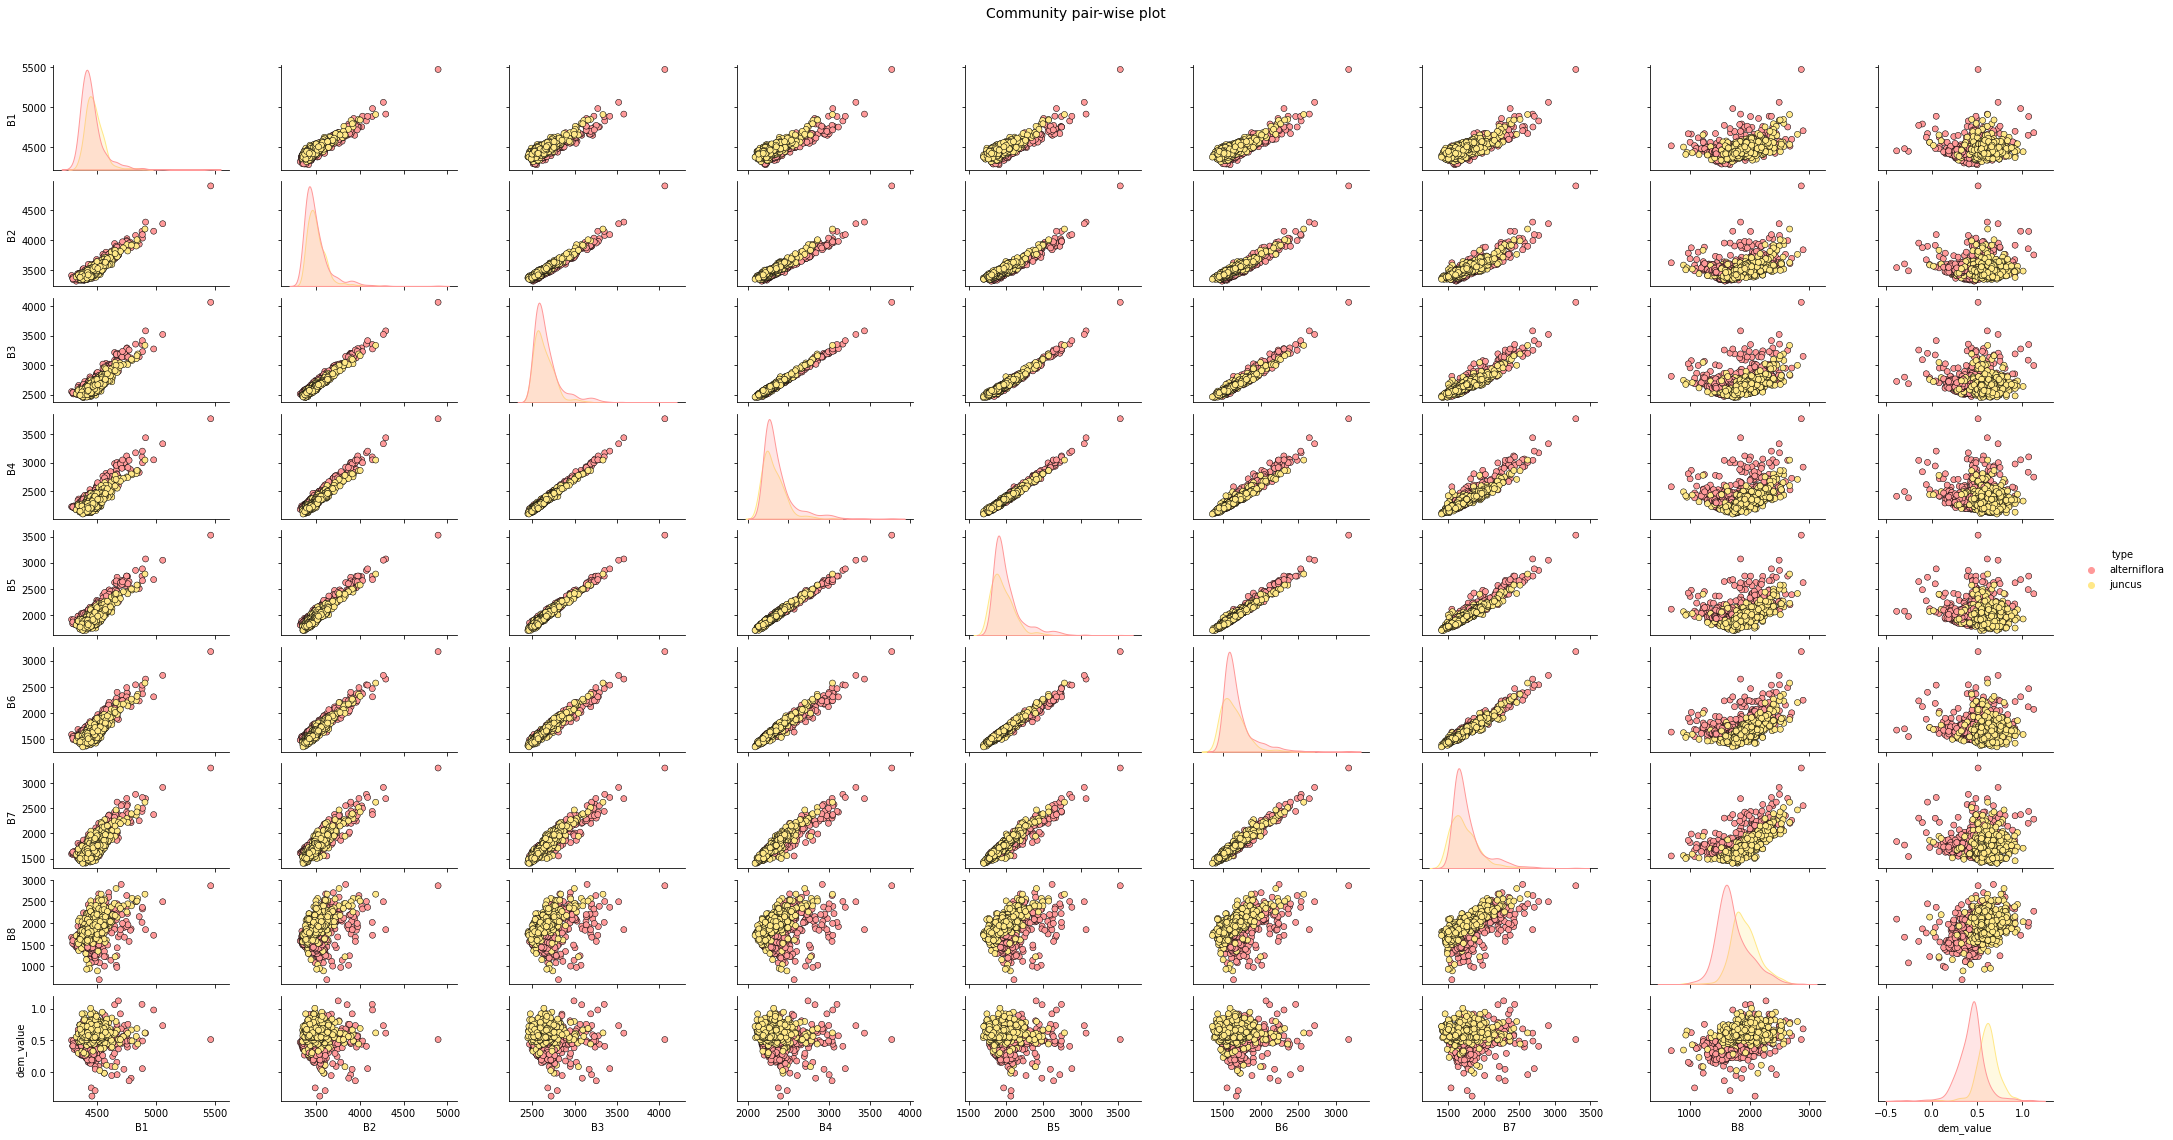

In [194]:
# Scatter Plot with Hue for visualizing data in 3-D
cols = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'type', 'dem_value']
pp = sns.pairplot(df[cols], hue='type', size=1.8, aspect=1.8, 
                  palette={"alterniflora": "#FF9999", "juncus": "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Community pair-wise plot', fontsize=14)
plt.savefig('../figures/{}_pair_wise_plot.png'.format(seasonal), facecolor=(1, 1, 1))

### Aggregate into mean value of each band and check on the distribution

<AxesSubplot:>

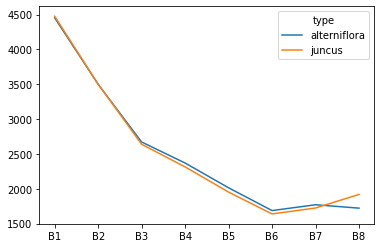

In [195]:
# data visualization of each band
new_df = df.drop(columns=['dem_value'], inplace=False)
grouped_df = new_df.groupby('type').mean()
grouped_df = grouped_df.T
index = pd.Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8'])
grouped_df = grouped_df.set_index(index)
grouped_df.plot()

In [196]:
grouped_df

type,alterniflora,juncus
B1,4454.191027,4477.230159
B2,3499.415340,3502.583333
B3,2670.842258,2638.230159
B4,2368.819103,2313.498016
B5,2012.976845,1951.291667
B6,1685.826339,1637.859127
B7,1769.641100,1722.654762
B8,1720.674385,1917.722222


Text(0, 0.5, 'NIR Band')

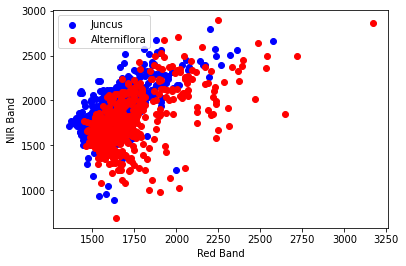

In [197]:
# Making the plot of Red and NIR band for each class
y = df['type']          # Split off classifications
X = df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']] # Split off features

plt.scatter(X[y=='juncus']['B6'], X[y=='juncus']['B8'], label='Juncus', c='blue')
plt.scatter(X[y=='alterniflora']['B6'], X[y=='alterniflora']['B8'], label='Alterniflora', c='red')

# Prettify the graph
plt.legend()
plt.xlabel('Red Band')
plt.ylabel('NIR Band')

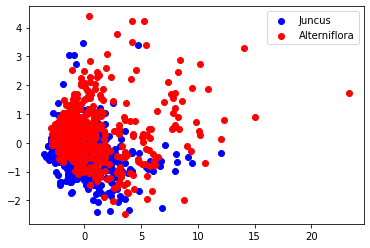

In [198]:
# PCA
from sklearn.decomposition import PCA as sklearnPCA

# y = df['type']          # Split off classifications
# X = df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']] # Split off features
# X_norm = (X - X.min())/(X.max() - X.min()) # need to refine

y = final_df['type']
X_norm = final_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']]

pca = sklearnPCA(n_components=2) #2-dimensional PCA
pca_transformed = pd.DataFrame(pca.fit_transform(X_norm))

plt.scatter(pca_transformed[y=='juncus'][0], pca_transformed[y=='juncus'][1], label='Juncus', c='blue')
plt.scatter(pca_transformed[y=='alterniflora'][0], pca_transformed[y=='alterniflora'][1], label='Alterniflora', c='red')

plt.legend()
plt.show()

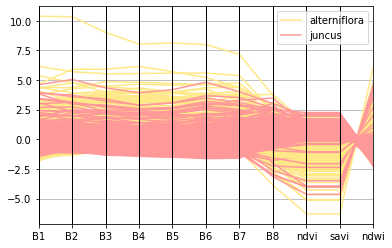

In [199]:
# get NDVI
df['ndvi'] = gdf.apply(lambda x: (x['B8'] - x['B6']) / (x['B8'] + x['B6']), axis=1)

# get NDWI: since the SWIR band is not available for PlanetScope data to create bare soil index, the NDWI is created
# representing the moisture and water indicator for this analysis.
df['ndwi'] = gdf.apply(lambda x: (x['B4'] - x['B8']) / (x['B8'] + x['B4']), axis=1)
df['savi'] = gdf.apply(lambda x: helpers.cal_savi(x['B8'], x['B6']), axis=1)


# data scale
# Scaling attribute values to avoid few outiers
cols = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'ndvi', 'savi','ndwi']
subset_df = df[cols]

ss = StandardScaler()

scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
final_df = pd.concat([scaled_df, df['type']], axis=1)
final_df.head()

# plot parallel coordinates with NDVI
pc = parallel_coordinates(final_df, 'type', color=('#FFE888', '#FF9999'))

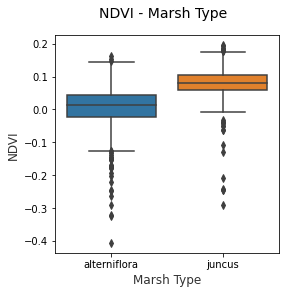

In [200]:
# NDVI distribution of each category

# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(4, 4))
f.suptitle('NDVI - Marsh Type', fontsize=14)

sns.boxplot(x="type", y="ndvi", data=df,  ax=ax)
ax.set_xlabel("Marsh Type",size = 12,alpha=0.8)
ax.set_ylabel("NDVI",size = 12,alpha=0.8)

plt.savefig('../figures/{}_boxplot_ndvi.png'.format(seasonal), facecolor=(1, 1, 1))

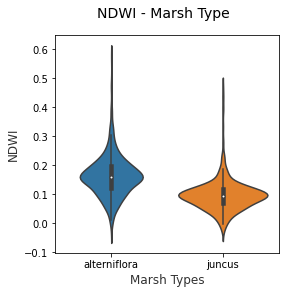

In [201]:
# Violin Plots of NDWI

f, (ax) = plt.subplots(1, 1, figsize=(4, 4))
f.suptitle('NDWI - Marsh Type', fontsize=14)

sns.violinplot(x="type", y="ndwi", data=df,  ax=ax)
ax.set_xlabel("Marsh Types",size = 12,alpha=0.8)
ax.set_ylabel("NDWI",size = 12,alpha=0.8)

plt.savefig('../figures/{}_violin_ndwi.png'.format(seasonal), facecolor=(1, 1, 1))

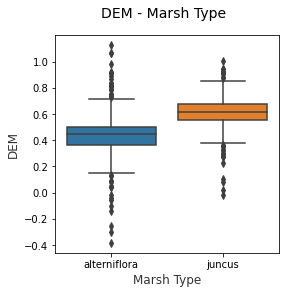

In [202]:
# DEM distribution of each category

# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(4, 4))
f.suptitle('DEM - Marsh Type', fontsize=14)

sns.boxplot(x="type", y="dem_value", data=df,  ax=ax)
ax.set_xlabel("Marsh Type",size = 12,alpha=0.8)
ax.set_ylabel("DEM",size = 12,alpha=0.8)

plt.savefig('../figures/{}_boxplot_dem.png'.format(seasonal), facecolor=(1, 1, 1))

In [203]:
df[df['ndvi']<0]

,id,type,layer,path,B1,B2,B3,B4,B5,B6,B7,B8,dem_value,ndvi,ndwi,savi
0,0,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4453,3500,2678,2393,2044,1651,1720,1229,0.481527,-0.146528,0.321369,-0.219754
2,2,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4500,3602,2802,2565,2211,1903,2005,1841,0.214749,-0.016560,0.164321,-0.024836
3,3,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4650,3855,3083,2828,2483,2121,2199,1930,1.062840,-0.047149,0.188735,-0.070715
4,4,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4650,3941,3213,2980,2620,2224,2423,2104,0.586897,-0.027726,0.172305,-0.041585
7,7,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4417,3495,2636,2296,1931,1597,1613,1403,0.201640,-0.064667,0.241417,-0.096984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,489,alterniflora,RandomPoints_Capt_Alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4549,3605,2765,2448,2118,1753,1798,1658,0.259103,-0.027851,0.192401,-0.041770
878,493,alterniflora,RandomPoints_Capt_Alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4456,3545,2719,2392,2009,1655,1727,1541,0.188089,-0.035670,0.216374,-0.053496
879,495,alterniflora,RandomPoints_Capt_Alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,4473,3538,2700,2423,2060,1709,1818,1540,0.277181,-0.052016,0.222811,-0.078012
910,30,juncus,RandomPoints_Capt_Juncus,/Users/mirandalv/Documents/projects/github/Mar...,4560,3598,2805,2494,2127,1763,1870,1635,0.561857,-0.037669,0.208041,-0.056496


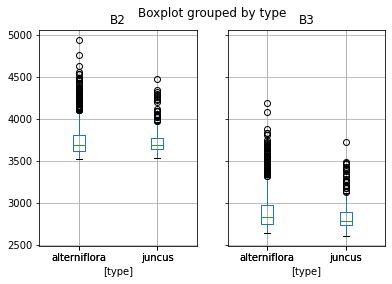

In [146]:
subdf = df[['B2', 'B3','type']]
boxplot = subdf.boxplot(by='type')

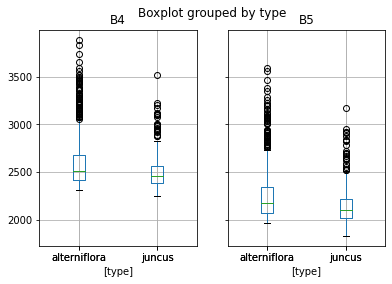

In [147]:
subdf = df[['B4', 'B5', 'type']]
boxplot = subdf.boxplot(by='type')

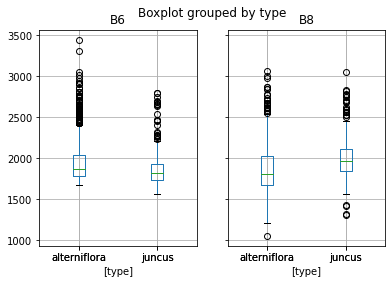

In [148]:
subdf = df[['B6', 'B8', 'type']]
boxplot = subdf.boxplot(by='type')

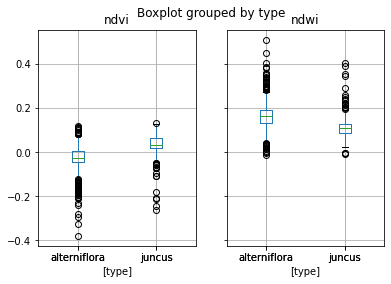

In [149]:
subdf = df[['ndvi', 'ndwi', 'type']]
boxplot = subdf.boxplot(by='type')

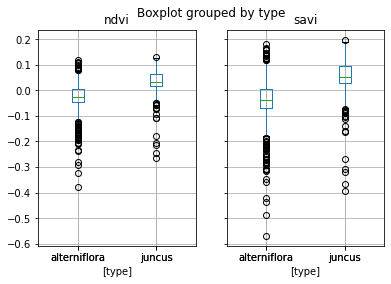

In [150]:
subdf = df[['ndvi', 'savi','type']]
boxplot = subdf.boxplot(by='type')

In [121]:
# Loading data
seasons = ['Jan-Mar_2022', 'Apr-Jun_2022', 'July-Sep_2022', 'Oct-Dec_2022']

df = pd.DataFrame()
for season in seasons:
    points_data = os.path.join(root_dir, 'data/processing_data/vectors/points_planet_comp_{}.geojson'.format(season))
    gdf = gpd.read_file(points_data)
    # gdf.drop(columns=['rand_point'], inplace=True)
    gdf.drop(columns=['type_class'], inplace=True)
    season_df = pd.DataFrame(gdf.drop(columns='geometry'))
    season_df['season'] = season
    df = pd.concat([df, season_df])

In [122]:
# get NDVI
df['ndvi'] = gdf.apply(lambda x: (x['B8'] - x['B6']) / (x['B8'] + x['B6']), axis=1)

# get NDWI: since the SWIR band is not available for PlanetScope data to create bare soil index, the NDWI is created
# representing the moisture and water indicator for this analysis.
df['ndwi'] = gdf.apply(lambda x: (x['B4'] - x['B8']) / (x['B8'] + x['B4']), axis=1)
df['savi'] = gdf.apply(lambda x: helpers.cal_savi(x['B8'], x['B6']), axis=1)

In [123]:
season_df = df[['id','ndvi', 'season', 'type']]

In [124]:
season_df

,id,ndvi,season,type
0,0,-0.146528,Jan-Mar_2022,alterniflora
1,1,0.027702,Jan-Mar_2022,alterniflora
2,2,-0.016560,Jan-Mar_2022,alterniflora
3,3,-0.047149,Jan-Mar_2022,alterniflora
4,4,-0.027726,Jan-Mar_2022,alterniflora
...,...,...,...,...
1190,986,0.108515,Oct-Dec_2022,juncus
1191,988,0.078717,Oct-Dec_2022,juncus
1192,989,0.071987,Oct-Dec_2022,juncus
1193,993,0.011364,Oct-Dec_2022,juncus
